<a href="https://colab.research.google.com/github/iamchaewon/RL-DDQN-Comparison/blob/main/RL_DDQN_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update
!apt-get install -y swig build-essential cmake

!pip install torch numpy matplotlib
!pip install box2d-py==2.3.5
!pip install gymnasium

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,201 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/u

In [4]:
import os
import numpy as np

# 1. 본인의 깃허브 주소 설정 (Raw 파일 주소여야 합니다)
# 주소 찾는 법: 깃허브에서 npy 파일 클릭 -> 'Download' 버튼 위에서 우클릭 -> '링크 주소 복사'
GITHUB_RAW_URL = "https://github.com/iamchaewon/RL-DDQN-Comparison/raw/refs/heads/main/all_experiment_results_2.npy"

DATA_FILENAME = "all_experiment_results_2.npy"

# 2. 파일이 없으면 깃허브에서 다운로드
if not os.path.exists(DATA_FILENAME):
    print(f"깃허브에서 실험 데이터({DATA_FILENAME})다운로드")
    os.system(f"wget {GITHUB_RAW_URL} -O {DATA_FILENAME}")
    print("다운로드 완료!")
else:
    print("데이터 파일이 이미 존재합니다.")

# 3. 로직 연결 (중간 저장 및 재시작 지원)
if os.path.exists(DATA_FILENAME):
    all_results = np.load(DATA_FILENAME, allow_pickle=True).item()
    print(f"{len(all_results)}개의 이전 실험 데이터를 로드했습니다. 바로 시각화할 수 있습니다.")
else:
    all_results = {}
    print("💡 이전 데이터가 없어 처음부터 학습을 시작합니다.")

# RESULTS_PATH를 로컬 경로로 변경 (남이 실행할 때 에러 방지)
RESULTS_PATH = DATA_FILENAME


깃허브에서 실험 데이터(all_experiment_results_2.npy)다운로드
다운로드 완료!
4개의 이전 실험 데이터를 로드했습니다. 바로 시각화할 수 있습니다.


In [5]:
# =========================
# 3. DQN / DDQN 에이전트 및 학습 함수 정의
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import random
from collections import deque
import matplotlib.pyplot as plt

# 환경 및 장치 설정
INPUT_DIM = 8     # LunarLander-v3 state dimension
OUTPUT_DIM = 4    # LunarLander-v3 discrete actions
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 0. Random Seed 고정 함수
def set_seed(seed):
    """모든 랜덤 소스를 고정해서 재현성을 높인다."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# 1. Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # state, next_state: (1, state_dim) 형태로 저장
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)

        return (
            torch.from_numpy(np.concatenate(state)).float().to(DEVICE),                # (B, 8)
            torch.from_numpy(np.array(action)).long().unsqueeze(1).to(DEVICE),        # (B, 1)
            torch.from_numpy(np.array(reward)).float().unsqueeze(1).to(DEVICE),       # (B, 1)
            torch.from_numpy(np.concatenate(next_state)).float().to(DEVICE),          # (B, 8)
            torch.from_numpy(np.array(done).astype(np.uint8)).float().unsqueeze(1).to(DEVICE)  # (B, 1)
        )

    def __len__(self):
        return len(self.buffer)


# 2. Q-Network
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# 3. Double DQN Agent
class DdqnAgent:
    """
    Double DQN:
    - Online Q-network(θ)로 argmax action 선택
    - Target Q-network(θ^-)로 해당 action의 값을 평가
    """
    def __init__(self, gamma=0.99, lr=5e-4, buffer_capacity=50000,
                 batch_size=64, target_update_freq=1000):
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq  # == C_freq
        self.update_counter = 0

        self.q_net = QNetwork(INPUT_DIM, OUTPUT_DIM).to(DEVICE)
        self.target_net = QNetwork(INPUT_DIM, OUTPUT_DIM).to(DEVICE)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.buffer = ReplayBuffer(buffer_capacity)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def get_action(self, state, epsilon):
        """ε-greedy 정책으로 action 선택."""
        if random.random() < epsilon:
            return random.randrange(OUTPUT_DIM)
        else:
            state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                q_values = self.q_net(state_tensor)
            return q_values.argmax().item()

    def update(self):
        if len(self.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)

        # 현재 Q(s, a)
        q_values = self.q_net(states).gather(1, actions)

        # Double DQN target 계산
        with torch.no_grad():
            # 1) online net으로 다음 상태에서의 argmax action 선택
            next_actions = self.q_net(next_states).argmax(1).unsqueeze(1)
            # 2) target net으로 해당 action의 값을 평가
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            # 3) done이면 다음 상태 값은 0
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        loss = self.loss_fn(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())


# 4. DQN Agent (DDQN에서 update만 다르게)
class DqnAgent(DdqnAgent):

    def update(self):
        if len(self.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)

        # 현재 Q(s, a)
        q_values = self.q_net(states).gather(1, actions)

        # DQN target 계산 (Max 연산 사용)
        with torch.no_grad():
            # target_net에서 바로 max Q(s', a) 사용
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        loss = self.loss_fn(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())


# 5. 학습 실행 함수
def run_experiment(agent_class, seed, target_update_freq,
                   max_episodes=500, eps_decay=0.995):

    # 파이썬 / NumPy / Torch seed 고정
    set_seed(seed)

    # Gym 환경 생성 및 seed 설정
    env = gym.make("LunarLander-v3")
    # 환경 및 action space seed (초기 한 번만)
    env.reset(seed=seed)
    env.action_space.seed(seed)

    agent = agent_class(lr=5e-4, target_update_freq=target_update_freq)

    EPS_START, EPS_END = 1.0, 0.01
    epsilon = EPS_START
    scores = []

    for episode in range(max_episodes):
        # episode마다 reset (seed는 위에서 한 번만 설정)
        state, info = env.reset()
        done = False
        total_reward = 0.0

        # ReplayBuffer에서 사용할 shape (1, 8)
        state_for_buffer = np.expand_dims(state, 0)

        while not done:
            action = agent.get_action(state, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            next_state_for_buffer = np.expand_dims(next_state, 0)

            agent.buffer.push(state_for_buffer, action, reward, next_state_for_buffer, done)
            agent.update()

            state = next_state
            state_for_buffer = next_state_for_buffer
            total_reward += reward

        scores.append(total_reward)
        epsilon = max(EPS_END, epsilon * eps_decay)

        if (episode + 1) % 50 == 0:
            avg_score = np.mean(scores[-100:])
            print(f"  > [E {episode+1:3d}] Avg Score (last 100): {avg_score:7.2f}")

    env.close()
    return np.array(scores)

In [6]:
# =========================
# 4. 실험 설정 / 실행 / 중간 저장
# =========================
SEEDS = [10, 20, 30]
MAX_EPISODES = 500

# 실험 목록: 알고리즘 비교 + C_freq(C) 변경 실험
experiments = {
    "DDQN (Baseline)":   {"agent": DdqnAgent, "C_freq": 1000},
    "DQN (Baseline)":    {"agent": DqnAgent,  "C_freq": 1000},
    "DDQN (C=100)":      {"agent": DdqnAgent, "C_freq": 100},
    "DDQN (C=10000)":    {"agent": DdqnAgent, "C_freq": 10000},
}

# 이전 결과 로드 (있으면 이어서, 없으면 새로)
try:
    if os.path.exists(RESULTS_PATH):
        all_results = np.load(RESULTS_PATH, allow_pickle=True).item()
        print(f"Drive에서 {len(all_results)}개의 이전 실험 그룹 결과를 로드했습니다. 이어서 진행합니다.")
    else:
        all_results = {}
        print("💡 이전 실험 결과 파일이 없습니다. 처음부터 시작합니다.")
except NameError:
    all_results = {}
    print("⚠️ 경고: RESULTS_PATH가 정의되지 않아 Drive 저장이 실패할 수 있습니다. 2번 셀을 먼저 실행하십시오.")

print(f"\n--- 총 {len(experiments) * len(SEEDS)}개의 실험을 시작합니다 (각 {MAX_EPISODES} 에피소드) ---")

for name, params in experiments.items():
    agent_class = params["agent"]
    C_freq = params["C_freq"]

    if name not in all_results:
        all_results[name] = []

    completed_seeds_count = len(all_results[name])

    for i, seed in enumerate(SEEDS):
        # 이미 저장된 seed는 건너뛰기
        if i < completed_seeds_count:
            print(f"[건너뛰기] {name} | Seed: {seed}는 이미 완료되었습니다.")
            continue

        print(f"\n[실행 중] {name} | Seed: {seed} | C_freq: {C_freq}")

        scores = run_experiment(agent_class, seed, C_freq, MAX_EPISODES)
        all_results[name].append(scores)

        # 매 seed마다 Drive에 중간 저장
        np.save(RESULTS_PATH, all_results)
        print(f"  --> [중간 저장 완료] {name}의 Seed {seed} 결과가 Drive에 백업되었습니다.")


Drive에서 4개의 이전 실험 그룹 결과를 로드했습니다. 이어서 진행합니다.

--- 총 12개의 실험을 시작합니다 (각 500 에피소드) ---
[건너뛰기] DDQN (Baseline) | Seed: 10는 이미 완료되었습니다.
[건너뛰기] DDQN (Baseline) | Seed: 20는 이미 완료되었습니다.
[건너뛰기] DDQN (Baseline) | Seed: 30는 이미 완료되었습니다.
[건너뛰기] DQN (Baseline) | Seed: 10는 이미 완료되었습니다.
[건너뛰기] DQN (Baseline) | Seed: 20는 이미 완료되었습니다.
[건너뛰기] DQN (Baseline) | Seed: 30는 이미 완료되었습니다.
[건너뛰기] DDQN (C=100) | Seed: 10는 이미 완료되었습니다.
[건너뛰기] DDQN (C=100) | Seed: 20는 이미 완료되었습니다.
[건너뛰기] DDQN (C=100) | Seed: 30는 이미 완료되었습니다.
[건너뛰기] DDQN (C=10000) | Seed: 10는 이미 완료되었습니다.
[건너뛰기] DDQN (C=10000) | Seed: 20는 이미 완료되었습니다.
[건너뛰기] DDQN (C=10000) | Seed: 30는 이미 완료되었습니다.


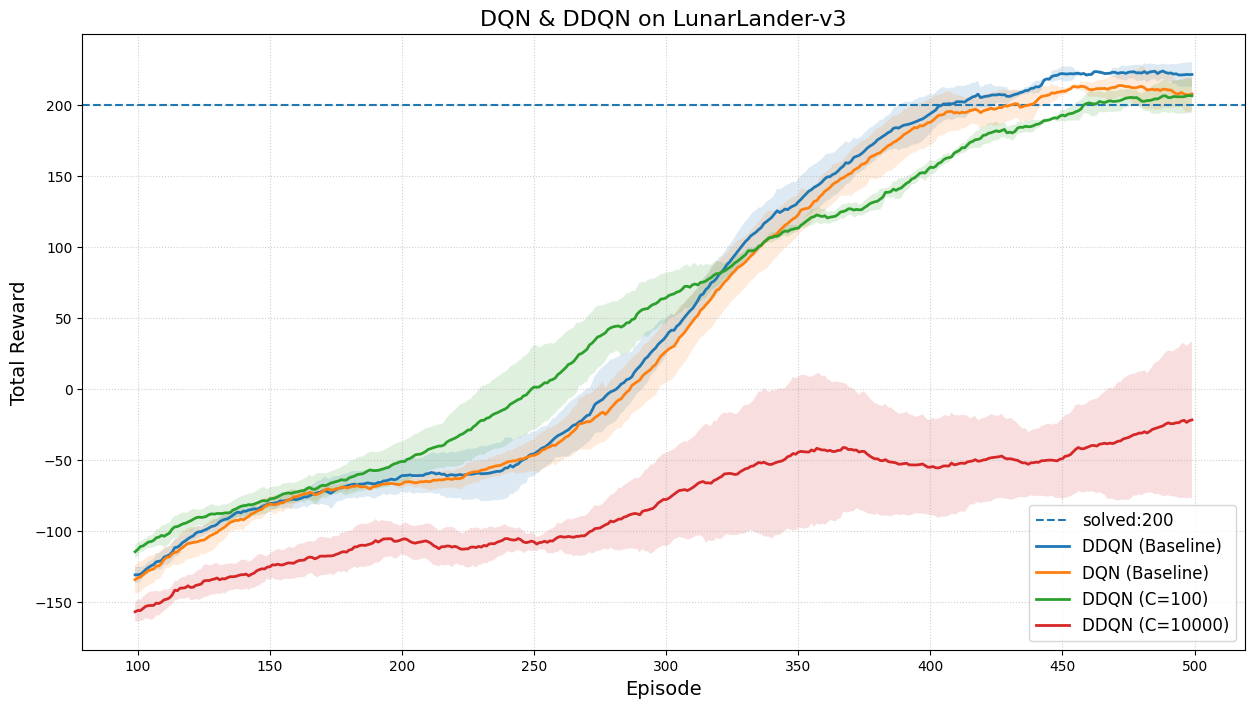

In [7]:
# =========================
# 5. 신뢰구간 포함 학습 곡선 시각화
# =========================
def plot_confidence_intervals(results_dict, window=100):
    plt.figure(figsize=(15, 8))
    plt.title('DQN & DDQN on LunarLander-v3', fontsize=16)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel(f'Total Reward', fontsize=14)
    plt.axhline(y=200, linestyle='--', label='solved:200')
    plt.grid(True, linestyle=':', alpha=0.6)

    for name, score_list in results_dict.items():
        scores = np.array(score_list)     # shape: (num_seeds, num_episodes)

        # 1. 이동 평균 (100-episode moving average)
        rolling_means = np.apply_along_axis(
            lambda x: np.convolve(x, np.ones(window)/window, mode='valid'),
            axis=1,
            arr=scores
        )

        # 2. seed별 평균 / 표준편차
        mean_scores = np.mean(rolling_means, axis=0)
        std_scores = np.std(rolling_means, axis=0)

        # 3. 신뢰구간
        ci_lower = mean_scores - std_scores
        ci_upper = mean_scores + std_scores

        x_axis = np.arange(len(mean_scores))

        plt.plot(x_axis + window - 1, mean_scores, label=name, linewidth=2)
        plt.fill_between(x_axis + window - 1, ci_lower, ci_upper, alpha=0.15)

    plt.legend(loc='lower right', fontsize=12)

    # 저장 경로 및 파일명 (예: './results/final_graphs/ddqn_comparison.png')
    save_path = "comparison_results.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# 시각화 실행
if 'all_results' in locals() and len(all_results) > 0:
    plot_confidence_intervals(all_results, window=100)
else:
    print("실험 결과 데이터가 없습니다.  먼저 실행해 주세요.")